In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [168]:
df = pd.read_csv('./data_for_modelling.csv')

In [169]:
df.drop(['min_sal', 'monthly_sal', 'max_sal'], axis=1, inplace=True)

In [170]:
num_df = df.select_dtypes(exclude = 'object')
cat_df = df.select_dtypes(include = 'object')

After using standard scaler, min-max scaler and log transform log transform turned out to be most suitable for our distribution as the other two scaling methods failed to deal with outliers effectively 

In [171]:
num_df['avg_yearly_sal'] = num_df['avg_yearly_sal'].apply(lambda x: np.log(x) if x>0 else 0)

<ipython-input-171-81ff5d350291>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['avg_yearly_sal'] = num_df['avg_yearly_sal'].apply(lambda x: np.log(x) if x>0 else 0)


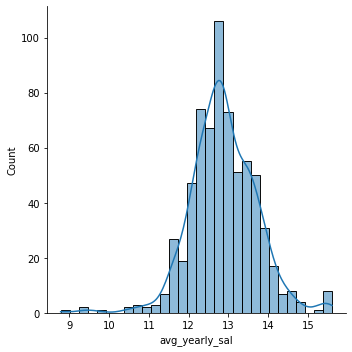

In [172]:
sns.displot(num_df[num_df['avg_yearly_sal']>0]['avg_yearly_sal'], kde=True)

Now our annual salary distribution looks quite uniform

Lets do the train test split

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(num_df.drop('avg_yearly_sal', axis=1), num_df['avg_yearly_sal'], test_size=0.2, random_state=42)

In [174]:
from sklearn.ensemble import RandomForestRegressor

In [175]:
rnd_reg = RandomForestRegressor(oob_score=True)

In [176]:
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(oob_score=True)

In [177]:
col_names = num_df.drop('avg_yearly_sal', axis=1).columns

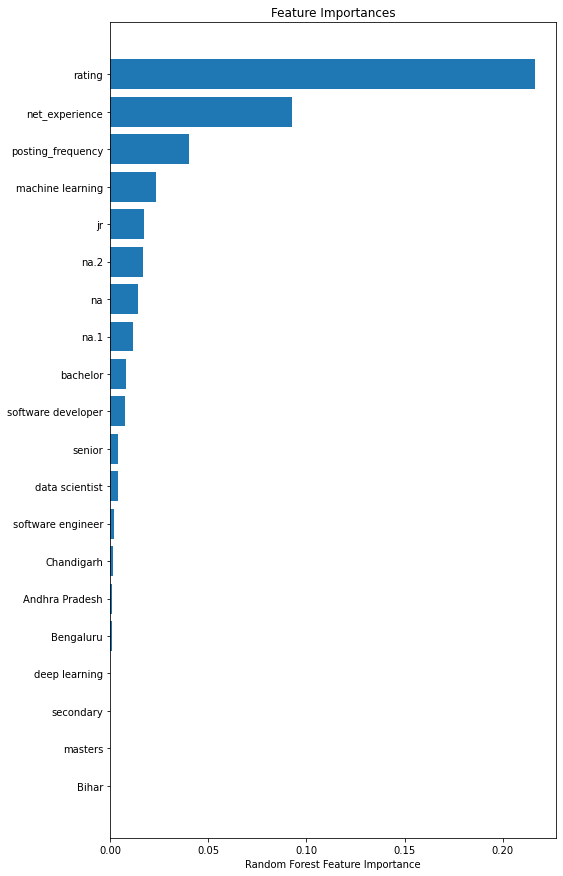

In [178]:
plt.figure(figsize=(8,15))
importances = rnd_reg.feature_importances_ [:20]
idxs = np.argsort(importances) 
plt.title('Feature Importances') 
plt.barh(range(len(idxs)), importances[idxs], align='center') 
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs]) 
plt.xlabel('Random Forest Feature Importance') 
plt.show() 

In [179]:
rnd_reg.oob_score_

0.25612747016069204

In [180]:
import statsmodels.api as sm

In [181]:
X_sm = sm.add_constant(X_train)

In [182]:
model = sm.OLS(y_train, X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_yearly_sal   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     6.757
Date:                Fri, 08 Jan 2021   Prob (F-statistic):           4.62e-47
Time:                        21:49:05   Log-Likelihood:                -2726.9
No. Observations:                 899   AIC:                             5602.
Df Residuals:                     825   BIC:                             5957.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9867      1.749      2.279      0.023       0.553       7.421
rating                -0.0447      0.005     -9.696      0.000      -0.054      -0.036
posting_frequency      0.0043      0.001      4.060      0.000       0.002       0.006
net_experience         0.0289      0.004      7.154      0.000       0.021       0.037
bachelor              -0.2377      1.654     -0.144      0.886      -3.485       3.010
masters                7.7675      5.204      1.492      0.136      -2.448      17.983
na                    -2.2461      1.545     -1.454      0.146      -5.279       0.787
secondary             -1.2970      2.551     -0.508      0.611      -6.305       3.711
jr                     0.3707      0.761      0.487      0.626      -1.124       1.865
na.1                   1.6909      0.661      2.560      0.011       0.394       2.988
senior                 1.9250      0.859      2.242      0.025       0.240       3.611
data scientist        -2.0085      1.473     -1.364      0.173      -4.899       0.882
deep learning          4.6709      2.700      1.730      0.084      -0.629       9.970
machine learning      -1.5664      0.871     -1.799      0.072      -3.276       0.143
na.2                   1.3906      0.712      1.952      0.051      -0.008       2.789
software developer     1.8435      1.193      1.545      0.123      -0.498       4.185
software engineer     -0.3434      1.367     -0.251      0.802      -3.026       2.339
Andhra Pradesh         0.6809      2.033      0.335      0.738      -3.310       4.671
Bengaluru              4.6823      3.701      1.265      0.206      -2.582      11.947
Bihar                  1.8531      5.210      0.356      0.722      -8.374      12.080
Chandigarh             0.6419      2.193      0.293      0.770      -3.663       4.947
Chhattisgarh          -5.7123      3.047     -1.875      0.061     -11.692       0.268
Delhi                  0.5428      0.636      0.854      0.394      -0.705       1.791
Goa                   -3.5130      2.642     -1.330      0.184      -8.698       1.672
Gujarat               -0.9982      1.162     -0.859      0.391      -3.279       1.283
Haryana               -0.4366      0.795     -0.549      0.583      -1.998       1.125
Hyderabad             -0.5130      1.995     -0.257      0.797      -4.429       3.403
India                 -3.7362      1.182     -3.161      0.002      -6.056      -1.416
Jharkhand             -0.1866      2.591     -0.072      0.943      -5.272       4.898
Karnataka             -0.5453      0.617     -0.884      0.377      -1.757       0.666
Kerala                 1.5312      0.981      1.561      0.119      -0.395       3.457
Madhya Pradesh         5.2125      1.678      3.106      0.002       1.919       8.506
Maharashtra           -1.6945      0.7

In [183]:
df[df['avg_yearly_sal']>0]

,Job_position,Company,Location,requirements,rating,experience,posting_frequency,avg_yearly_sal,net_experience,education_level,...,api,js,cleaning,algorithms,architecture,information,jquery,bootstrap,react,apis
0,na,Gather Network,"Urban Estate Gurgaon, Haryana",blockchain,-99.0,na,1.0,240000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,na,Agile Placement,"Pune, Maharashtra",java spark python r,-99.0,Total work: 6 years,1.0,950000.0,6,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,na,Client of PlaceElements HR,"Thiruvananthapuram, Kerala",NaN,-99.0,Python: Algorithms: Statistics: 1 yearData Sci...,1.0,750000.0,2,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,na,Teqlinx Software Solutions LLC,"Bengaluru, Karnataka",structures,-99.0,na,1.0,3000000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,java,www.yansisofsol.com,"Hyderabad, Telangana",cleaning,-99.0,na,1.0,342000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,java,megna super It solutions private limited,"Hyderabad, Telangana",java,-99.0,na,1.0,540000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120,na,Welkin Smartcard Business pvt. Ltd.,"Bhopal, Madhya Pradesh",mvc,-99.0,na,1.0,270000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1121,stack,Perfect Plan B Private Limited - Edtech Indust...,"Faridabad, Haryana",stack,-99.0,na,1.0,360000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1122,stack,Programmics Technology,"Raipur, Chhattisgarh",mobile,-99.0,Full Stack Developer: 1 year,1.0,210000.0,1,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

In [187]:
lin_reg = LinearRegression()

In [188]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [192]:
scores = cross_val_score(lin_reg, X_train, y_train, cv=4, verbose=3, scoring='neg_mean_squared_error')

[CV]  ................................................................
[CV] .................................. , score=-27.025, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.999, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.071, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.150, total=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


In [198]:
np.exp(np.mean(np.sqrt(-scores)))

250.3498400581757

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-28.244, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.004, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.542, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-26.221, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.211, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.651, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.073, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.545, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.083, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.290, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.547, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.077, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.289, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-29.549, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.071, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.288, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.551, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.066, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.287, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-29.561, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.037, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.281, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.233, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.564, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.032, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.280, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur


[CV]  ................................................................
[CV] .................................. , score=-34.020, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.278, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.570, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.015, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.277, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.234, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.004, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.275, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.235, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.576, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.998, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.274, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.236, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-33.993, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.273, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.237, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.581, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.987, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.272, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.240, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-29.583, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.982, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.271, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.245, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.585, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.976, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.270, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-29.587, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.971, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.269, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.256, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.590, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.966, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.268, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.960, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.267, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.267, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.594, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.955, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.266, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.272, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.278, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.599, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.944, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.283, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.601, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.939, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.289, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.604, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.933, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.263, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.295, total=   0.0s
[CV]  ................................................................

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................. , score=-29.606, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.928, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.262, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.300, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.608, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.923, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.261, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.918, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.261, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.311, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.613, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.912, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.260, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.317, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.323, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.618, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.902, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.258, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.328, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.621, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.897, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.892, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.257, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.340, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.626, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.887, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.256, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.345, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.881, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.255, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.351, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.631, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.876, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.255, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.357, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.871, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.254, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.363, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.636, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.866, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.253, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.369, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-29.641, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.856, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.252, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.380, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.643, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.851, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.252, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-27.392, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.649, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.841, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.250, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.398, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.651, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.836, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-27.404, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.654, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.831, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.249, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.410, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.657, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.826, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.821, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.248, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.421, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.662, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.816, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.248, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.427, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.433, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.668, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.806, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.247, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.439, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.670, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.802, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-29.673, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.797, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.246, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.451, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.676, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.792, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.245, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.457, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.679, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.787, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.245, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.463, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.682, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.782, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-27.470, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.684, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.778, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.244, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.476, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.687, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.773, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.244, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.482, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.690, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.768, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.243, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.488, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.693, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................. , score=-33.763, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.243, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.494, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.696, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.759, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.243, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.500, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.699, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.754, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.242, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.506, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.702, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.749, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.242, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.519, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.708, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.740, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.242, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.710, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.735, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-27.531, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.713, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.731, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.241, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.538, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.716, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.726, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.241, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.550, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.723, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.717, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.556, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.726, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-27.563, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.729, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.708, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.569, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.732, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.704, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.582, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.738, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.695, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.588, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.741, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-29.744, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.686, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.601, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.747, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.681, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.673, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.621, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.757, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.668, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.627, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.643, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.667, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.780, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.638, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.673, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.687, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.790, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.626, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.693, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.793, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-27.707, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.800, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.613, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.713, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.803, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.609, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-27.727, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.810, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.601, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.734, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.814, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.597, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV] .................................. , score=-27.747, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.820, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.589, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.241, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.754, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.824, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.585, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.577, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.241, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.775, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.835, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.573, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.242, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.782, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-27.795, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.845, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.561, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.243, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.802, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.849, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.557, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-27.816, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.856, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.550, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.244, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.823, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.860, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.546, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-29.867, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.538, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.245, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.845, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.871, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.535, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.245, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.527, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.246, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.866, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.882, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.523, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.247, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.873, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.516, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.248, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.887, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.893, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.512, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.248, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.894, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.505, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.249, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.909, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.905, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.501, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.250, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.916, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-33.498, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.250, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.923, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.913, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.494, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.251, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.931, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-29.920, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.487, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.252, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.945, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.924, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.483, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.253, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.932, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.476, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.254, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.967, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.936, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.473, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.255, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.466, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.256, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.948, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.463, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.257, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-27.997, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.258, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.012, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.960, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.452, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.259, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.019, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.964, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.446, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.260, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.034, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.972, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.442, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.261, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.042, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.977, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.439, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.262, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.049, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.981, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.436, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.263, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.264, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.064, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.429, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.264, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.072, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.993, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.080, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.997, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.423, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.266, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.087, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.002, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-28.095, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.006, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.416, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.268, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.102, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.010, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.413, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-32.273, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.141, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.031, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.398, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.274, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.149, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.036, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.391, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.276, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.164, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.044, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.388, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.277, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.172, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-28.188, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.058, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.379, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.280, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.196, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.062, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.376, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.282, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.212, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.071, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.371, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.283, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.219, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.075, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-32.285, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.235, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.084, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.362, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.286, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.243, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.089, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-30.098, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.353, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.290, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.267, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.102, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.351, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.291, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.345, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.294, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.292, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.116, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.342, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.295, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.300, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-28.316, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.130, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.334, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.299, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.324, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.135, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.331, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-32.303, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.349, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.149, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.323, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.304, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.357, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.154, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-28.373, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.163, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.316, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.308, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.381, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.168, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.313, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV] .................................. , score=-30.177, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.308, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.312, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.406, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.182, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.305, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.314, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.192, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.301, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.317, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.431, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.197, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.298, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.318, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.296, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.320, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.448, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.207, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.293, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.321, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.457, total=   0.0s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.211, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.291, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.323, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.465, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.216, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.288, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.324, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.221, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.286, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.326, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.482, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.226, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.284, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.328, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-32.329, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.499, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.236, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.279, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.331, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.507, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.241, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.332, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.516, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.246, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.274, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.334, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.251, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-30.256, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.270, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.337, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.542, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.261, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.268, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.339, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.341, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.559, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.272, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.263, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.342, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.568, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-32.344, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.576, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.282, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.259, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.346, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.585, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.287, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-28.594, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.292, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.255, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.349, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.602, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.297, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.252, total=   0.0s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.351, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.611, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.302, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.250, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.353, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.620, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.308, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.355, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.629, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.313, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.246, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.357, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.637, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.318, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-32.360, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.655, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.328, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.362, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.664, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.334, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.238, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.364, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.673, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.339, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.236, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.366, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.681, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.370, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.699, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.355, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.230, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.372, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.708, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.360, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-30.366, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.227, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.376, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.726, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.371, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.225, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.378, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.221, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.382, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.753, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.387, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.219, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.384, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.762, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-30.398, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.216, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.388, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.780, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.404, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.214, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.390, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.409, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.212, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.392, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.798, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-30.415, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.210, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.394, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.807, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.420, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.209, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.396, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.426, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.207, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.398, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.826, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.431, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.205, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.400, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.437, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.204, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.402, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.844, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.442, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.202, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.405, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-28.853, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.448, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.200, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.407, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.862, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.454, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.199, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-28.872, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.459, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.197, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.411, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.881, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.465, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.196, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-28.899, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.476, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.192, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.418, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.909, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.482, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.191, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.189, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.422, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.927, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.493, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.188, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.425, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.937, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-30.499, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.186, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.427, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.946, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.505, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.185, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.429, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-32.432, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.965, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.516, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.182, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.434, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.974, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.522, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.179, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.439, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-28.993, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.534, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.178, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.441, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.003, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.173, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.451, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.041, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.563, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.171, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.453, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.050, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-32.456, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.060, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.575, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.169, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.458, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.069, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.581, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.461, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.079, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.587, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.166, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.463, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.089, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.593, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.098, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.599, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.164, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.468, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.108, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.605, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.163, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.162, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.473, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.127, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.617, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.161, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.476, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.137, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.481, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.156, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.635, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.157, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.484, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.166, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.641, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.647, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.155, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.489, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.186, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.653, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.154, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.492, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.494, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.205, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.666, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.152, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.497, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.215, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.672, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.225, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.678, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.150, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.503, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.235, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.684, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.149, total=   0.0s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.505, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.245, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.690, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.149, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.508, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.255, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.697, total=   0.0s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.148, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.511, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.703, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.147, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.514, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.275, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.285, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.715, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.145, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.519, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.295, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.722, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.144, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.305, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.728, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.143, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.315, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.734, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.143, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.741, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.142, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.531, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.335, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.747, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.141, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.534, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-33.140, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.536, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.355, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.760, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.140, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.539, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.365, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-33.138, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.545, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.385, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.779, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.137, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.548, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.395, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-29.405, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.792, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.136, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.554, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.416, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.798, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.136, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.135, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.560, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.436, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.811, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.134, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.563, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.446, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.569, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.467, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.831, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.133, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.572, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.477, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.838, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-29.498, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.851, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.131, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.582, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.508, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.857, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.131, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-30.871, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.130, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.591, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.539, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.877, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.129, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.594, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.129, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.601, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.571, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.897, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.128, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.604, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.581, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-29.591, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.911, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.128, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.610, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.602, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.918, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.127, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-32.613, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.612, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.924, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.127, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.617, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.623, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.931, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-32.623, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.644, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.945, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.126, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.627, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.655, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.952, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.630, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.665, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.959, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.126, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.633, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.676, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-30.965, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.126, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.637, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.687, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.972, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.640, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.643, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.708, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.986, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.647, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.719, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.993, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.650, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.729, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.000, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.654, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.740, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.007, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.761, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.021, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.664, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.772, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.028, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.783, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.035, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.671, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.794, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.042, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-31.049, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.678, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.815, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.056, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.681, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-32.685, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.837, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.070, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.689, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.848, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.077, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-29.870, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.091, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.699, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.881, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.099, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.903, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.113, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.126, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.710, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.914, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.120, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.126, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-29.936, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.135, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.126, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.721, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.947, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.142, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.127, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-29.969, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.156, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.127, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.732, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-29.980, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.164, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.127, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.171, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.128, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.740, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.002, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.178, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.128, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.744, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.025, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.193, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.129, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.751, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.036, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.200, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.129, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.215, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.130, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.763, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.070, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.222, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.130, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.767, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-31.237, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.131, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.774, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.103, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.245, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.132, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.778, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.133, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.786, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.137, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.267, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.133, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.790, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.149, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-32.798, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.171, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.290, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.135, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.802, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.183, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.297, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-30.194, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.305, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.136, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.810, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.206, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.313, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.137, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-31.320, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.138, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.818, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.229, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.328, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.138, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.822, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.139, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.826, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.252, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.343, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.140, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.830, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.263, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.141, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.835, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.275, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.358, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.141, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.839, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.286, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-32.843, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.298, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.374, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.143, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.847, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.309, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.382, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.144, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.855, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.333, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.397, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.145, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.859, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.344, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.413, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.147, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.868, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.368, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.420, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.148, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.872, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.436, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.150, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.881, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.403, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.444, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.151, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.885, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-31.452, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.152, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.889, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.426, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.460, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.153, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.893, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.468, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.154, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.898, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.450, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.475, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.155, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.902, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-30.474, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.491, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.157, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.911, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.485, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.499, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.158, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.507, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.159, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.920, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.509, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.515, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.160, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.924, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.928, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.533, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.531, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.162, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.933, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.545, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.539, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.164, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.942, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.569, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.555, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.166, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.946, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.581, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-31.572, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.168, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.955, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.605, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.580, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.169, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.960, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-31.596, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.172, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.969, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.641, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.604, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.173, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.973, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV] .................................. , score=-30.677, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.629, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.177, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.987, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.690, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.637, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.178, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.662, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.183, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.006, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.738, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.670, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.184, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.010, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.015, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.763, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.687, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.187, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.020, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.775, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.695, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.190, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.029, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.800, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.712, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.191, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.034, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.812, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-33.043, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.837, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.737, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.196, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.048, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.849, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.745, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.204, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.072, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.911, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.787, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.206, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.077, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.924, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-30.936, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.804, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.209, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.087, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.949, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.813, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.211, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................. , score=-31.822, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.213, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.097, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.974, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.830, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.214, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.102, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.107, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-30.999, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.847, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.218, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.112, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.011, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.856, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.122, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.037, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.873, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.223, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.127, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.049, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.882, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.137, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.075, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.899, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.229, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.142, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.087, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.908, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.152, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.113, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.925, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.235, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.157, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.126, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.934, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-31.943, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.239, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.167, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.151, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.952, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.241, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.172, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.243, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.177, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.177, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.969, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.245, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.183, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.190, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................. , score=-31.978, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.247, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.188, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.202, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.987, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.249, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.193, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.228, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.005, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.253, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.203, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.241, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.014, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.255, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-32.031, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.259, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.219, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.280, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.040, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.262, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.224, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-33.268, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.240, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.332, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.076, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.270, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.246, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.345, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-32.103, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.277, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.262, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.384, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.112, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.280, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.267, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.131, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.284, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.278, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.424, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.140, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.287, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.284, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.149, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.289, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.289, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.450, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.158, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.291, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.294, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-33.294, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.300, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.476, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.176, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.296, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.305, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.489, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.503, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.195, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.301, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.316, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.516, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.204, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.304, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-31.543, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.222, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.309, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.333, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.556, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.231, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.311, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.344, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.583, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.250, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.316, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.350, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.596, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.259, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-33.361, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.623, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.278, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.324, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.367, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.636, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.287, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.297, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.329, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.378, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.663, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.306, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.332, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.384, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-33.389, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.690, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.325, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.338, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.395, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.703, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.334, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-31.731, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.353, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.346, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.412, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.744, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.363, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.349, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.424, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.771, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.382, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.354, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.430, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.785, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.391, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.441, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.812, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.410, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.363, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.447, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.826, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.420, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-31.853, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.439, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.371, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.465, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.867, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.449, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.374, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.468, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.380, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.483, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.908, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.477, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.383, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.489, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-31.949, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.506, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.392, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.507, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.963, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.516, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.395, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................. , score=-33.519, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-31.991, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.536, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.402, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.005, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.545, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.408, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.537, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.033, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.565, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.411, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.543, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.047, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-32.075, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.594, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.420, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.561, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.089, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.604, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.424, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-32.131, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.634, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.433, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.586, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.145, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.644, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.437, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.443, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.604, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.187, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.674, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.447, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.611, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.201, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.704, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.457, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.629, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.244, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.714, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.460, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.636, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-33.467, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.648, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.286, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.744, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.470, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.655, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.300, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-32.764, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.477, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.667, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.329, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.774, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.481, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.674, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-32.794, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.488, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.686, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.372, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.805, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.491, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.693, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV] .................................. , score=-33.699, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.401, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.825, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.499, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.706, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.415, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.835, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.719, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.444, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.856, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.510, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.725, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.458, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.866, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV] .................................. , score=-33.517, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.738, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.487, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.886, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.521, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.745, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.502, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.531, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.917, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.532, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.764, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.545, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.928, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.536, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.543, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.784, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.589, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.959, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.547, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.791, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.603, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV] .................................. , score=-33.804, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.633, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.990, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.559, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.811, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.647, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.000, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-33.021, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.570, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.831, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.691, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.032, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.574, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.838, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-32.736, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.063, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.586, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.858, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.750, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.074, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.590, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.598, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.878, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.795, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.106, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.602, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.885, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.810, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.610, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.899, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.839, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.138, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.615, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.906, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.854, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................. , score=-33.159, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.623, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.919, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.884, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.170, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.627, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.926, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.933, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.914, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.191, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.635, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.940, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.929, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.202, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-33.947, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.944, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.212, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.644, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.954, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.959, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.223, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. , score=-33.961, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.974, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.652, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.968, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-32.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.245, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-33.266, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.665, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.034, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.277, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.670, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.996, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.080, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.310, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.683, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.017, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.095, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.321, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.687, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.125, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.343, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.696, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.039, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.141, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.354, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.700, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-34.053, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.171, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.376, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.709, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.060, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.186, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.387, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.089, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.248, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.431, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.732, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.096, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.263, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.442, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-33.453, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.741, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.111, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.294, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.464, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.746, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.118, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.486, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.755, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.133, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.340, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.497, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.760, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.140, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.520, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.769, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.155, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.386, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.531, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.774, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.162, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.553, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.784, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.177, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.433, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.564, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.788, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.184, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-33.587, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.798, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.199, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.480, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.598, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.803, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.207, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-33.808, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.214, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.511, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.621, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.813, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.222, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.527, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-33.644, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.822, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.237, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.558, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.655, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.827, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.244, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.678, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.837, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.259, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.605, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.689, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.842, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.267, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-33.701, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.847, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.275, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.637, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.712, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.852, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.282, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.668, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.735, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.862, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.297, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.684, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.746, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.867, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.878, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.320, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.732, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.781, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.883, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.328, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.748, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-33.816, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.898, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.351, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.795, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.827, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.903, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.359, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.827, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.850, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.914, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.375, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.843, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.862, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.919, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-33.924, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.390, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.875, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.885, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.930, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.398, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.891, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-33.909, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.940, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.414, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.924, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.920, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.946, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.422, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-33.944, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.956, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.437, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.972, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.956, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.962, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.445, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-33.972, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.461, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.020, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.991, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-33.978, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.469, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.037, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-34.085, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.038, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.000, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.501, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.102, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.050, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.005, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.016, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.151, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.086, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.022, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.533, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.167, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.033, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.549, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.200, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.122, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.039, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.557, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.216, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-34.574, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.249, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.158, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.056, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.582, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.170, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-34.194, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.073, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.606, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.315, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.206, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.079, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.614, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.364, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.242, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.096, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.639, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.381, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.255, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.102, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.113, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.664, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.431, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.291, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.119, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.672, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.447, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-34.481, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.328, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.137, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.697, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.497, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.340, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.143, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.155, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.722, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.547, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.377, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.161, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.731, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.564, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-34.748, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.598, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.414, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.179, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.756, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.615, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.426, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.781, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.665, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.463, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.203, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.790, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.682, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-34.476, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.209, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.798, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.699, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.488, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.216, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.807, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-34.228, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.824, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.750, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.833, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.767, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.800, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.563, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.253, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.858, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.818, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.576, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.259, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-34.588, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.876, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.852, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.601, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.272, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.884, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-34.626, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.284, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.902, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.903, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.638, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.291, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.910, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.937, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.664, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.303, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.928, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.954, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.676, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.310, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-34.316, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.945, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.702, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.323, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.954, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.006, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.740, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.342, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.981, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.057, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.753, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.349, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.989, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.778, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.362, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.007, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.109, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.791, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.368, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.016, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-35.144, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.817, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.381, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.034, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.161, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.829, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.388, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV] .................................. , score=-35.060, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.213, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.868, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.408, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.069, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.231, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.881, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-35.096, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.283, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.920, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.435, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.105, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.301, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.933, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-34.959, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.455, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.132, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.353, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.972, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.462, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.142, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.475, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.160, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.406, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.011, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.482, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.169, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.424, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV] .................................. , score=-35.187, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.459, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.050, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.503, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.196, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.477, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.063, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV] .................................. , score=-34.524, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.224, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.530, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.103, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.531, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.233, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.547, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-35.155, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.559, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.270, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.618, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.169, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.566, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.279, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.580, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.298, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.672, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.208, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.587, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.307, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.690, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-35.316, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.708, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.235, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.602, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.326, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.726, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.248, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-35.761, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.275, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.623, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.354, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.779, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.288, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.630, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-35.373, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.815, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.315, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.645, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.382, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.833, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.329, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-34.659, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.401, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.869, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.356, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.667, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.411, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.888, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-35.924, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.396, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.689, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.439, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.942, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.409, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.696, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-35.978, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.437, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.711, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.468, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.996, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.450, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.718, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-34.733, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.497, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.051, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.491, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.741, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.506, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.069, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-35.518, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.756, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.525, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.106, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.532, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.763, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.535, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-36.142, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.559, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.778, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.554, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.160, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.573, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.786, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-34.801, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.584, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.215, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.614, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.809, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.593, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.234, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-36.271, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.655, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.832, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.623, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.289, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.669, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.839, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-34.855, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.652, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.345, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.711, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.863, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.662, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.363, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.400, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.752, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.886, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.692, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.419, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.766, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.894, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-35.721, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.474, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.808, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.917, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.731, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.493, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.822, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-35.791, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.605, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.906, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.973, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.801, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.624, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.920, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-35.948, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-34.997, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.832, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.680, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.962, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.005, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.842, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-36.715, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.005, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.030, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.872, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.726, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.019, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.038, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-35.054, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.903, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.759, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.062, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.062, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.913, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.770, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.793, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.105, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.087, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.943, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.804, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.119, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.095, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-35.974, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.837, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.162, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.120, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.985, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.848, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.176, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-35.137, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.005, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.871, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.205, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.145, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.016, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.882, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-36.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.162, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.036, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.904, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.248, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.170, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.047, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................. , score=-36.263, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.179, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.057, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.927, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.277, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.187, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.067, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-35.204, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.088, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.961, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.320, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.213, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.099, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.972, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-35.230, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.120, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.995, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.364, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.238, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.130, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.006, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.017, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.393, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.255, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.151, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.029, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.408, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.264, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV] .................................. , score=-35.273, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.172, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.051, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.437, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.281, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.183, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.063, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-37.086, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.481, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.307, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.215, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.097, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.496, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.316, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-36.247, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.131, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.540, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.342, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.257, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.143, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.555, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.584, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.369, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.289, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.177, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.599, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.377, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.300, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-37.212, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.643, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.404, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.332, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.223, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.658, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.413, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-35.431, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.365, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.258, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.703, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.440, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.376, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.270, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.281, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.733, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.458, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.397, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.293, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.748, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.467, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-36.441, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.339, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.808, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.503, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.452, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.351, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.823, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.374, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.853, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.530, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.485, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.386, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.868, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.539, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-36.883, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.549, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.507, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.410, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.898, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.558, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.518, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-35.576, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.540, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.445, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.943, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.585, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.551, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.457, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.573, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.480, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.613, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.584, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.492, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.004, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-37.516, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.035, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.641, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.617, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.528, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.050, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.650, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.651, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.563, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.096, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.679, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.662, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.575, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.111, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-37.599, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.142, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.707, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.696, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.611, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.157, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.716, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-36.718, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.635, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.188, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.735, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.729, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.647, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.203, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-37.219, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.754, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.752, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.670, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.764, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.763, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-37.250, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.774, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.775, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.694, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.265, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.783, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.786, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.296, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.802, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.809, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.731, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.311, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.812, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.820, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-35.822, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.832, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.755, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.343, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.831, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.843, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.767, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................. , score=-37.374, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.851, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.866, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.791, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.389, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.861, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.877, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-35.880, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.900, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.827, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.436, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.890, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.912, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.839, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.935, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.864, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.483, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.919, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.946, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.876, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.499, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-37.530, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.949, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.981, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.912, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.546, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.959, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.993, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-37.016, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.949, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.593, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-35.989, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.028, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.961, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.609, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV] .................................. , score=-37.641, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.019, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.063, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.998, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.657, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.029, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.074, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.133, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.072, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.752, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.089, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.145, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.084, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.768, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain

[CV]  ................................................................
[CV] .................................. , score=-37.800, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.120, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.180, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.121, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.816, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.130, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.192, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-38.146, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.848, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.150, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.216, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.159, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.864, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.161, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish

[CV]  ................................................................
[CV] .................................. , score=-37.896, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.181, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.252, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.196, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.912, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.192, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.264, total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-37.288, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.234, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.961, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.223, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.299, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.246, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.977, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-38.009, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.254, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.335, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.284, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.025, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.264, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.348, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-36.275, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.360, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.309, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.058, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.285, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.372, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.321, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-36.306, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.396, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.346, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.106, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.317, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.408, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.359, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-38.384, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.155, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.348, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.444, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.397, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.172, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.359, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.505, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.460, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.254, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.412, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.517, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.473, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.270, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-38.303, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.444, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.554, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.511, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.319, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.455, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.566, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-38.550, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.369, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.487, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.603, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.562, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.385, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.498, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-37.640, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.601, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.435, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.530, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.653, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.614, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.452, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-38.485, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.563, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.690, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.652, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.502, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.574, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.703, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-37.715, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.678, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.535, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.596, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.727, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.691, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.552, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  ................................................................
[CV] .................................. , score=-37.752, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.717, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.585, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.629, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.765, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.730, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.602, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-37.790, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.756, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.635, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.662, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.803, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.768, total=   0.0s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-38.652, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.673, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.815, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.781, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.669, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.684, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.828, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-38.686, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.695, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.840, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.807, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.702, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.707, total=   0.0s
[CV]  ................................................................

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................. , score=-37.853, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.820, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.719, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.718, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.866, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.834, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.736, total=   0.0s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-37.891, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.860, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.770, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.751, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.904, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.873, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.787, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finish


[CV]  ................................................................
[CV] .................................. , score=-38.899, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.821, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.785, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.942, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.912, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.838, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.796, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remain


[CV]  ................................................................
[CV] .................................. , score=-36.819, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.980, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.951, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.889, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.830, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-37.993, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.964, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-38.957, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.876, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.044, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-39.017, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.974, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.887, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.057, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-39.008, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.910, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.082, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-39.057, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-39.025, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-36.922, total=   0.0s
[CV]  ................................................................
[CV] .................................. , score=-38.095, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] .................................. , score=-39.083, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


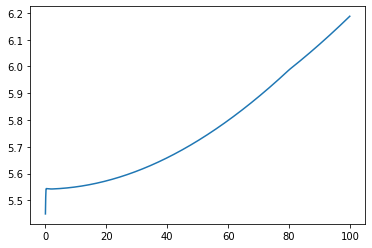

In [207]:
error = []
alpha = []
for i in range(1,100):
    alpha.append(i/10)
    lasso= Lasso(alpha=i/10)
    scores = cross_val_score(lasso, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    error.append(np.mean(np.sqrt(-scores)))
plt.plot(alpha, error)

In [208]:
lasso = Lasso(alpha=0.2)
scores = cross_val_score(lasso, X_train, y_train, cv=3, scoring='neg_mean_squared_error')


In [209]:
np.exp(np.mean(np.sqrt(-scores)))

250.2334932513374